# __SpringBoard Capstone Project 1: Data Storytelling__
## __(Cervical Cancer Dataset)__

__Written by: Sofy Weisenberg__<br>
__Date: 12/16/19__

__Step 1: Importing the Dataset and Data Preparation__<br>
Import the original dataset and perform data wrangling steps to prepare data for analysis (for details on these steps, see: https://github.com/s-weisenberg/Springboard/blob/master/Capstone_Project_1/Capstone1_Data_Wrangling.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df = df.replace('?', np.nan)
for column, values in df.iteritems():
        df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.fillna(df.median())
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,4.0,3.0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,4.0,3.0,0,0,0,0,0,0,0,0


__Step 2: Quantifying the target variables in the sample__

__Question__: What proportion of the sample population is positive (indicated by 1) for each of the target variables? 


In [2]:
df.loc[:,['Hinselmann','Schiller','Citology','Biopsy']].sum()/df.loc[:,['Hinselmann','Schiller','Citology','Biopsy']].count()

Hinselmann    0.040793
Schiller      0.086247
Citology      0.051282
Biopsy        0.064103
dtype: float64

__Conclusion__: With such a small proportion of positive samples in the dataset, it will be important to utilize the appropriate metrics for model performance. Overall accuracy for modeling any single target variable will likely not be a meaningful metric (for example, if the model simply predicted all negative results for the target variables, it could have a >95% overall accuracy, but it would not be a good model for predicting which patients actually have cervical cancer). Metrics such as sensitivity, specificity, and positive/negative predictive values are better at evaluating diagnostic performance. Models could be compared on the ROC curve to look for improvements in model performance.

__Step 3: Looking for strong correlations in the data__

__Question__: Which explanatory variables have the strongest correlation to each of the target variables? 

A heat map of the correlation coefficients between each of the different variables could give a quick indication of the relative strengths of the different correlations, where either high or low extremes indicate a strong correlation. In the plot below, this is accomplished with the size of the marker at each variable intersection indicating the (absolute) strength of the correlation.

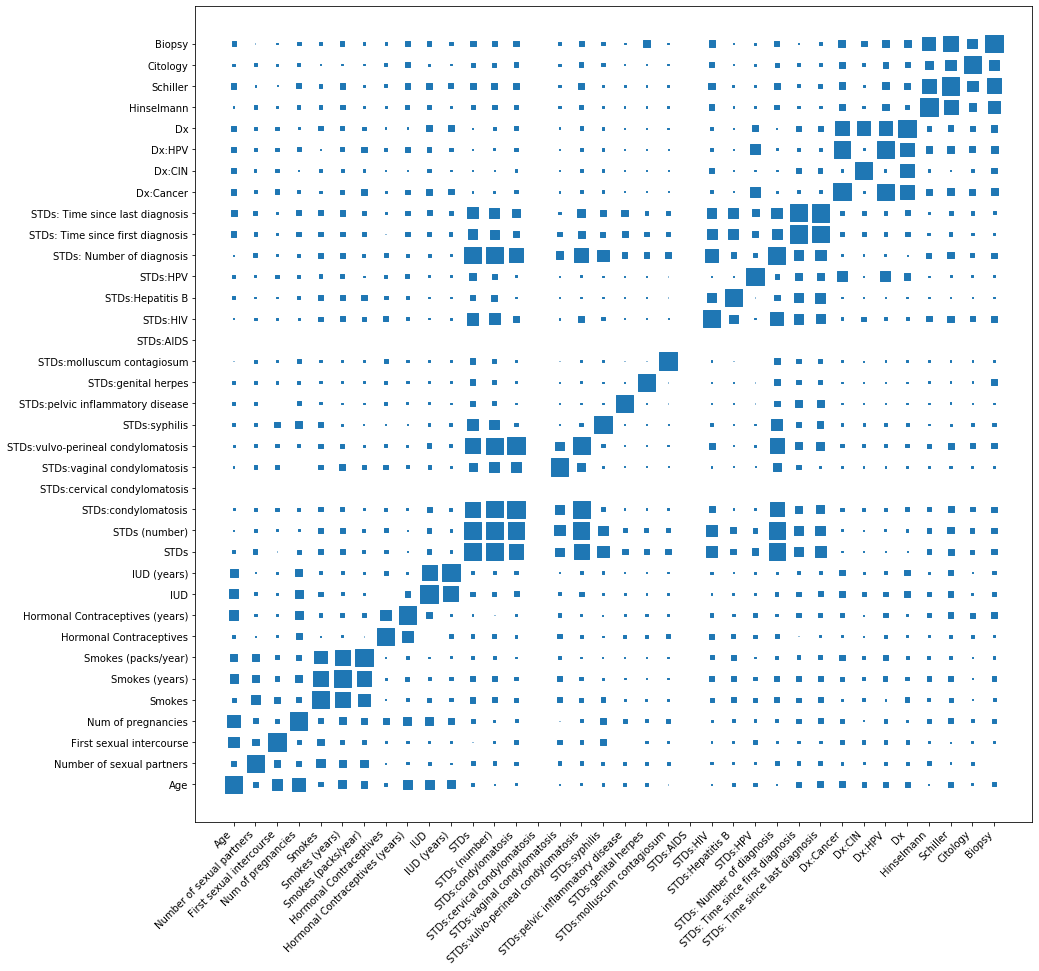

In [3]:
def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(15,15))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 300
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
columns = df.columns
corr = df[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'corr_coeff']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['corr_coeff'].abs()
)

__Note__: 2 variables STDs:cervical condylomatosis and STDs:AIDs are all 0 values after imputation and therefore a correlation coefficient cannot be calculated for these variables. 

From the plot above, a few general relationships may be observed:
- related variables have high correlations to one another (for example, the target variables to one another, the smoking history variables, the STD variables, etc.)
- the Dx (diagnosis) group of explanatory variables appear to have strong correlation to all target variables, and to a lesser extent, some of the STD group and hormonal contraceptive group<br>

These observations can be further explored by looking at the top 10 correlation coefficients for each of the target variables (see below).

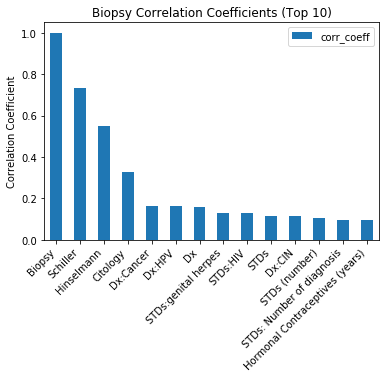

In [4]:
# Filter the correlation coefficients for 'Biopsy' target variable. 
biopsy_corr = corr[corr.y == 'Biopsy']
# Sort by absolute value of the correlation coefficients and remove any NaN.
biopsy_corr = biopsy_corr.reindex(biopsy_corr.corr_coeff.abs().sort_values(ascending=False).index).dropna().set_index('y')
# Show only the top 14 (correlation to the other 4 target variables and top 10 explanatory variables.)
ax = biopsy_corr.head(14).plot.bar(x='x', y='corr_coeff')
ax.set_xticklabels(biopsy_corr.x, rotation=45, horizontalalignment='right')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.title('Biopsy Correlation Coefficients (Top 10)')
plt.show()

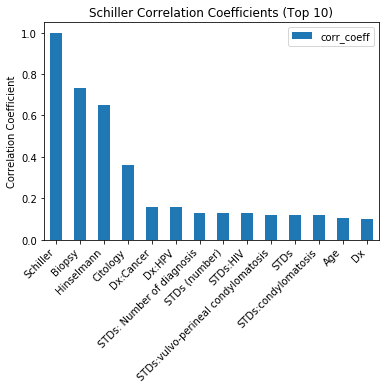

In [5]:
schiller_corr = corr[corr.y == 'Schiller']
schiller_corr = schiller_corr.reindex(schiller_corr.corr_coeff.abs().sort_values(ascending=False).index).dropna().set_index('y')
ax = schiller_corr.head(14).plot.bar(x='x', y='corr_coeff')
ax.set_xticklabels(schiller_corr.x, rotation=45, horizontalalignment='right')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.title('Schiller Correlation Coefficients (Top 10)')
plt.show()

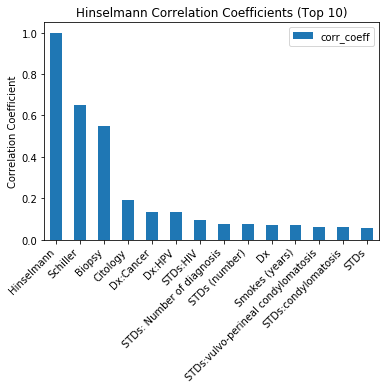

In [6]:
hinselmann_corr = corr[corr.y == 'Hinselmann']
hinselmann_corr = hinselmann_corr.reindex(hinselmann_corr.corr_coeff.abs().sort_values(ascending=False).index).dropna().set_index('y')
ax = hinselmann_corr.head(14).plot.bar(x='x', y='corr_coeff')
ax.set_xticklabels(hinselmann_corr.x, rotation=45, horizontalalignment='right')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.title('Hinselmann Correlation Coefficients (Top 10)')
plt.show()


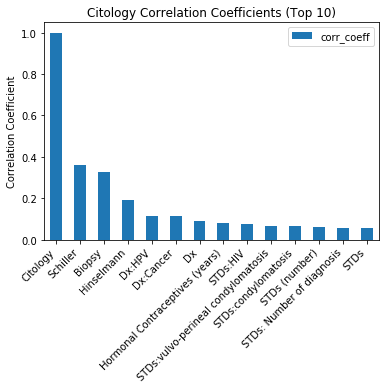

In [7]:
citology_corr = corr[corr.y == 'Citology']
citology_corr = citology_corr.reindex(citology_corr.corr_coeff.abs().sort_values(ascending=False).index).dropna().set_index('y')
citology_corr.head(14)
ax = citology_corr.head(14).plot.bar(x='x', y='corr_coeff')
ax.set_xticklabels(citology_corr.x, rotation=45, horizontalalignment='right')
plt.xlabel(None)
plt.ylabel('Correlation Coefficient')
plt.title('Citology Correlation Coefficients (Top 10)')
plt.show()

From the above breakdown of the top 10 correlation coefficients for each of the explanatory variables, the following observations may be made:
- the Dx:Cancer, Dx:HPV have the strongest correlation with all 4 of the target variables.
- total number of STDs and number of diagnosis (of HPV?) as well as years of hormonal contraceptive use also seem to have strong correlations across the board.

These observations will help guide subsequent statistical modeling and machine learning.